In [1]:
import pandas as pd
import json
from datetime import datetime, timedelta
import calendar
import requests
import json
import pytz
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Reading and cleaning car-sharing data

All the data could be downloaded on: http://netlab.ice.ufjf.br/index.php/carsharingdata/

In [2]:
def evo_cleaning(data):
    # only travels with more than 30 minutes of duration, 
    # that is the cancellation time limit of a booking
    data = data.loc[(data['duration'] > 30) | (data['distance'] > 3)]

    data.Start_time = pd.to_datetime(data.Start_time)
    data.End_time = pd.to_datetime(data.End_time)

    # Colleting vehicle ids
    car_ids = list(data.Id.unique())

    # Removing uncommon ids
    # Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
    ids_uncommon = [id for id in car_ids if id.find('-') != -1]
    car_ids = [id for id in car_ids if id.find('-') == -1]

    data = data.loc[~data.Id.isin(ids_uncommon)]
    
    # Removing microseconds from the dates
    data.Start_time = data.Start_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    data.End_time = data.End_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    
    return data

In [3]:
# reading data
evo_data = pd.read_csv('data/evo_travels.csv')
modo_data = pd.read_csv('data/modo_travels.csv')
c2g_data = pd.read_csv('data/car2go_travels.csv', index_col=0)

In [4]:
# cleaning process
# time will have a hour granularity
evo_data = evo_cleaning(evo_data)

modo_data.start = modo_data.start.apply(lambda x: datetime.fromtimestamp(x))
modo_data.start = modo_data.start.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
modo_data.end = modo_data.end.apply(lambda x: datetime.fromtimestamp(x))
modo_data.end = modo_data.end.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))

c2g_data.init_time = c2g_data.init_time.apply(lambda x: datetime.fromtimestamp(x))
c2g_data.init_time = c2g_data.init_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
c2g_data.final_time = c2g_data.final_time.apply(lambda x: datetime.fromtimestamp(x))
c2g_data.final_time = c2g_data.final_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))

### Preparing the demand series

In [5]:
# organization of the data for the model

# count travel occurency by hour
evo_travel_count = evo_data.Start_time.value_counts(sort=False)
evo_travel_count = evo_travel_count.sort_index()
modo_travel_count = modo_data.start.value_counts(sort=False)
modo_travel_count = modo_travel_count.sort_index()
c2g_travel_count = c2g_data.init_time.value_counts(sort=False)
c2g_travel_count = c2g_travel_count.sort_index()

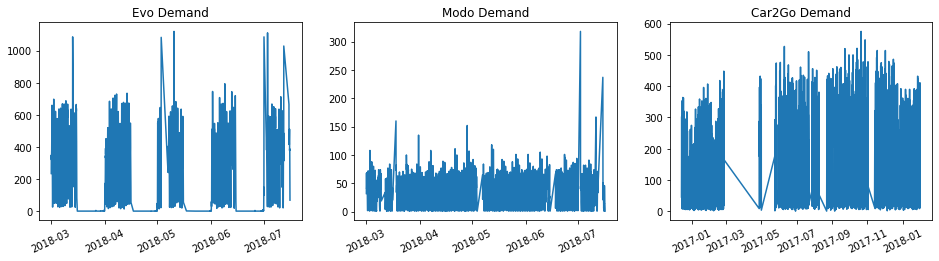

In [6]:
plt.figure(figsize=(16,8))

plt.subplot(2,3,1)
plt.title('Evo Demand')
plt.plot(evo_travel_count.index, evo_travel_count)
plt.xticks(rotation=25)

plt.subplot(2,3,2)
plt.title('Modo Demand')
plt.plot(modo_travel_count.index, modo_travel_count)
plt.xticks(rotation=25)

plt.subplot(2,3,3)
plt.title('Car2Go Demand')
plt.plot(c2g_travel_count.index, c2g_travel_count)
plt.xticks(rotation=25)
plt.show()

## Collecting weather data

Data provided by <a href="https://www.worldweatheronline.com/" title="world weather online" target="_blank">world weather online</a>. Learn more about the <a href="https://www.worldweatheronline.com/developer/api/docs/historical-weather-api.aspx" title="meteostat Sources" target="_blank">historical weather api</a>.

### Preparing list of days to collect

In [7]:
# filtering only unique dates from the datetimes
evo_days = list(evo_data.Start_time.apply(lambda x: x.replace(hour=0)).unique())
modo_days = list(modo_data.start.apply(lambda x: x.replace(hour=0)).unique())
c2g_days = list(c2g_data.init_time.apply(lambda x: x.replace(hour=0)).unique())

# list of all unique dates collected
days_to_collect = list(set(evo_days + modo_days + c2g_days))
days_to_collect = list(map(lambda date: pd.to_datetime(date), days_to_collect))
days_to_collect.sort()

# Converting to unix timestamp
timestamps_to_collect = list(map(lambda date: int(pd.Timestamp(date).timestamp()), days_to_collect))

In [8]:
days_to_collect[-8:-1]

[Timestamp('2018-07-07 00:00:00'),
 Timestamp('2018-07-08 00:00:00'),
 Timestamp('2018-07-09 00:00:00'),
 Timestamp('2018-07-10 00:00:00'),
 Timestamp('2018-07-11 00:00:00'),
 Timestamp('2018-07-12 00:00:00'),
 Timestamp('2018-07-15 00:00:00')]

In [9]:
timestamps_to_collect[-8:-1]

[1530921600,
 1531008000,
 1531094400,
 1531180800,
 1531267200,
 1531353600,
 1531612800]

### Reading weather data

In [10]:
# read weather dataset
weather_data = pd.read_csv('data/weather_data.csv', index_col=0)
weather_data.index = pd.to_datetime(weather_data.index)

In [11]:
weather_data.head()

,time,tempC,tempF,windspeedMiles,windspeedKmph,winddirDegree,winddir16Point,weatherCode,weatherIconUrl,weatherDesc,...,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex
2016-01-01 00:00:00,0,0,31,2,3,12,NNE,113,[{'value': 'http://cdn.worldweatheronline.net/...,[{'value': 'Clear'}],...,41,-3,26,5,41,2,4,5,41,1
2016-01-01 01:00:00,100,-1,31,2,4,21,NNE,113,[{'value': 'http://cdn.worldweatheronline.net/...,[{'value': 'Clear'}],...,40,-3,26,4,39,3,4,4,39,1
2016-01-01 02:00:00,200,-1,31,3,4,31,NNE,113,[{'value': 'http://cdn.worldweatheronline.net/...,[{'value': 'Clear'}],...,39,-3,26,3,38,3,5,3,38,1
2016-01-01 03:00:00,300,-1,30,3,5,41,NE,113,[{'value': 'http://cdn.worldweatheronline.net/...,[{'value': 'Clear'}],...,38,-3,26,2,36,4,6,2,36,1
2016-01-01 04:00:00,400,-1,30,3,5,39,NE,113,[{'value': 'http://cdn.worldweatheronline.net/...,[{'value': 'Clear'}],...,38,-3,26,2,36,3,6,2,36,1


## Creating the carsharing demand datasets

Selecting just few columns of the weather data

In [12]:
weather_data.columns

Index(['time', 'tempC', 'tempF', 'windspeedMiles', 'windspeedKmph',
       'winddirDegree', 'winddir16Point', 'weatherCode', 'weatherIconUrl',
       'weatherDesc', 'precipMM', 'precipInches', 'humidity', 'visibility',
       'visibilityMiles', 'pressure', 'pressureInches', 'cloudcover',
       'HeatIndexC', 'HeatIndexF', 'DewPointC', 'DewPointF', 'WindChillC',
       'WindChillF', 'WindGustMiles', 'WindGustKmph', 'FeelsLikeC',
       'FeelsLikeF', 'uvIndex'],
      dtype='object')

In [13]:
weather_data.weatherDesc = weather_data.weatherDesc.apply(lambda x: x[12:-3]) # get the weather description
weatherDesc_dummy = pd.get_dummies(weather_data.weatherDesc) # dummy the weather description
weather_data = weather_data.join(weatherDesc_dummy)

In [14]:
dummy_columns = weatherDesc_dummy.columns
weather_data = weather_data[['tempC','precipMM','FeelsLikeC','uvIndex','visibility','windspeedMiles'] + list(dummy_columns)]

In [ ]:
weather_data.plot(subplots=True, figsize=(12,8))
plt.show()

### Merge datasets

In [108]:
evo_weather = evo_travel_count.to_frame(name='travels').join(weather_data)
modo_weather = modo_travel_count.to_frame(name='travels').join(weather_data)
c2g_weather = c2g_travel_count.to_frame(name='travels').join(weather_data)

In [109]:
weather_data.index.sort_values()

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq=None)

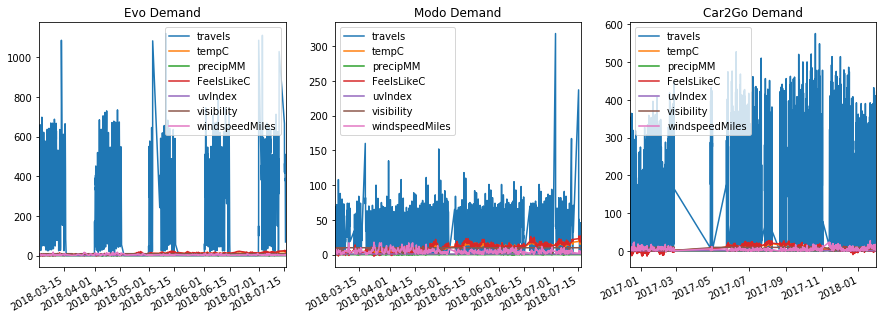

In [114]:
columns = ['travels','tempC','precipMM','FeelsLikeC','uvIndex','visibility','windspeedMiles']
fig, axes = plt.subplots(1,3,figsize=(15,5))

evo_weather[columns].plot(ax=axes[0], title='Evo Demand')
plt.xticks(rotation=25)

modo_weather[columns].plot(ax=axes[1], title='Modo Demand')
plt.xticks(rotation=25)

c2g_weather[columns].plot(ax=axes[2], title='Car2Go Demand')
plt.xticks(rotation=25)

plt.show()

In [115]:
evo_weather.to_csv('data/demand_datasets/evo_demand.csv', encoding='utf-8')
modo_weather.to_csv('data/demand_datasets/modo_demand.csv', encoding='utf-8')
c2g_weather.to_csv('data/demand_datasets/c2g_demand.csv', encoding='utf-8')